# Naive bayes classifier: Google Play Store reviews

## 1. Data Loading

In [18]:
# Handle import up-front
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

from utils import cross_val

### 1.1. Load the data

In [5]:
# Load the data from the URL provided in the project tutorial
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')

### 1.2. Inspect the data

In [6]:
data_df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


### 1.3. Train-test split

In [8]:
# Separate features from labels
labels=data_df['polarity']
features=data_df.drop('polarity', axis=1)

# Split the data into training and testing features and labels
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.25,
    random_state=315
)

### 1.4. Data encoding

In [9]:
# Get just the reviews from the training data
training_reviews=training_features['review']

# Fit the vectorizer and transform the training reviews into word counts
vec_model=CountVectorizer(stop_words="english")
training_word_counts=vec_model.fit_transform(training_reviews).toarray()

print(f'Word count matrix has {training_word_counts.shape[0]} rows and {training_word_counts.shape[1]} columns')

Word count matrix has 668 rows and 3151 columns


## 2. EDA

### 2.1. Baseline model performance

In [10]:
# Define the model
model=MultinomialNB()

# Cross-validate the model
scores=cross_val(model, training_word_counts, training_labels)

Cross-validation accuracy: 80.99 +/- 4.17%


### 2.2. Missing, and/or extreme values

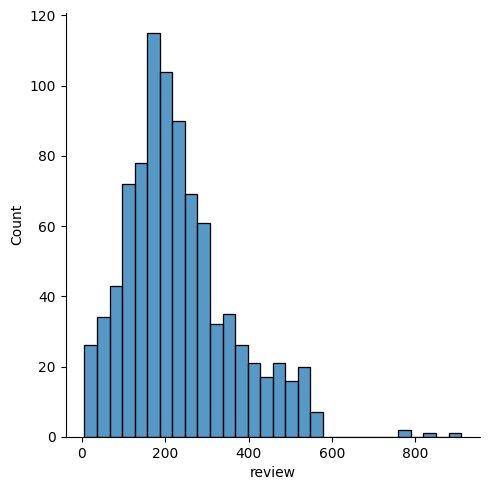

In [ ]:
# Try plotting the distribution of review lengths!

data_df['review'] = data_df.review.apply(len)
sns.displot(data_df,x='review')

### 2.3. Feature selection

In [ ]:
# After encoding we have over three thousand features - do we need all of them? Try plotting the distribution of word counts!

# Your code here...

## 3. Model training

In [ ]:
# Initialize and fit GaussianNB

model = GaussianNB()
model.fit(training_word_counts, training_labels)

GaussianNB()

## 4. Model optimization

In [ ]:
# For this project we will compare the three types of naive bayes models avalible in Scikit-learn: GaussianNB, MultinomialNB or BernoulliNB, rather than running hyperparameter optimization. Also, feel free to experiment and try any other tricks or methods you can find via research or come up with yourself to improve model performance!

# Your code here...

## 5. Final model evaluation